In [1]:
# Importing packages and setting the device.
from torchvision import datasets
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.lib.function_base import copy
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Download the training dataset and load
data_folder = '~/Documents/Projects/PyTorch/data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

In [2]:
# Set the variables
tr_images = fmnist.data
tr_targets = fmnist.targets

In [3]:
# Download the validation dataset and load
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [4]:
# Specify the augmentation to be performed on the image.
from imgaug import augmenters as iaa
aug = iaa.Sequential([
              iaa.Affine(translate_px={'x':(-10,10)}, mode='constant'),
            ])

In [10]:
# Define the Dataset class. 
# Takes the input images, their classes, and the augmentation object as initializers.
# ims is a tuple of tensor, and into the augment_images they call .copy() on each images
# Its waiting for a list of np.ndarray.
# To fix it, we need to stack tensor into a bigger one and then call the to_numpy() function.
def to_numpy(x: torch.Tensor) -> np.ndarray:
    return x.cpu().detach().numpy()

class FMNISTDataset(Dataset):
    def __init__(self, x, y, aug=None):
        self.x, self.y = x, y
        self.aug = aug
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        # debug---https://github.com/PacktPublishing/Modern-Computer-Vision-with-PyTorch/issues/62
        # if self.aug:
        #     x = self.aug.augment_image(x.numpy())
        #     x = torch.tensor(x).unsqueeze(0).float() / 255.0
        #     y = torch.tensor(y).long()
        return x, y
        return x, y
    def __len__(self): return len(self.x)

    def collate_fn(
        self, batch: list[tuple[torch.Tensor, torch.Tensor]]
    ) -> tuple[torch.Tensor, torch.Tensor]:
        ims, classes = zip(*batch)
        ims = torch.stack(ims)
        if self.aug:
            ims = self.aug.augment_images(images=to_numpy(ims))
        ims = torch.tensor(ims)[:, None, :, :] / 255.0
        classes = torch.tensor(classes)
        return ims, classes

In [11]:
# Define the model, optimizer and loss function.
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [12]:
# Function to train the dataset on a batch of images.
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [13]:
# Function that generates a training DataLoader from the dataset.
def get_data():
    train = FMNISTDataset(tr_images, tr_targets, aug=aug)
    'notice the collate_fn argument'
    trn_dl = DataLoader(train, batch_size=64,
                collate_fn=train.collate_fn, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images),
                collate_fn=val.collate_fn, shuffle=True)
    return trn_dl, val_dl

In [14]:
# Initialize the model, loss function and optimizer.
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()
for epoch in range(5):
    print(epoch)
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)

0
1
2
3
4


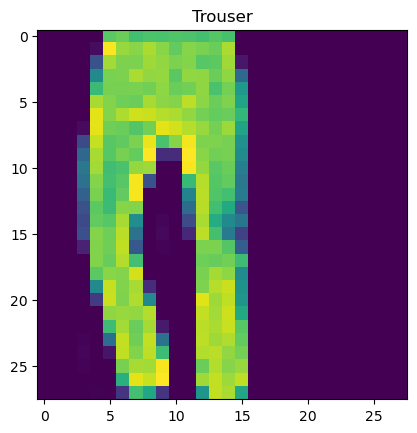

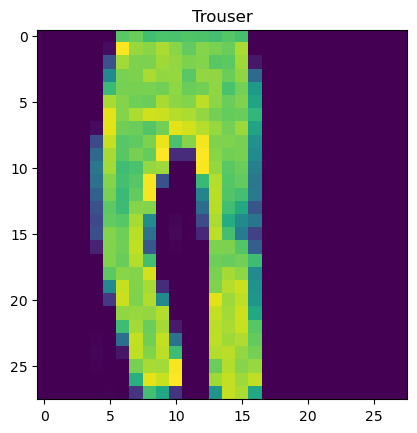

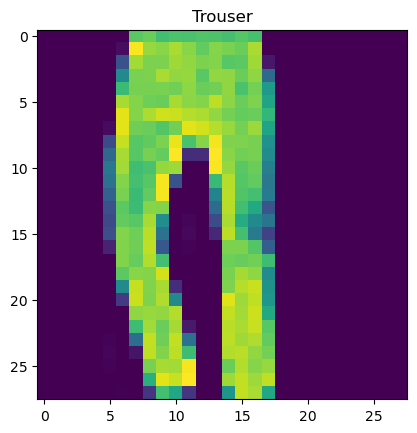

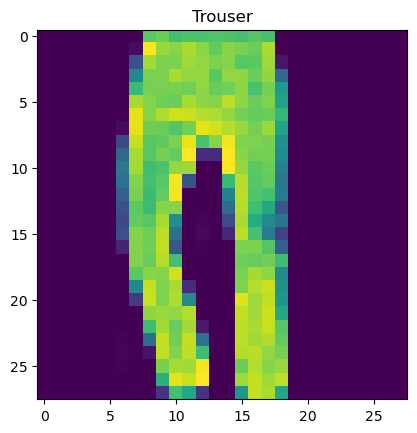

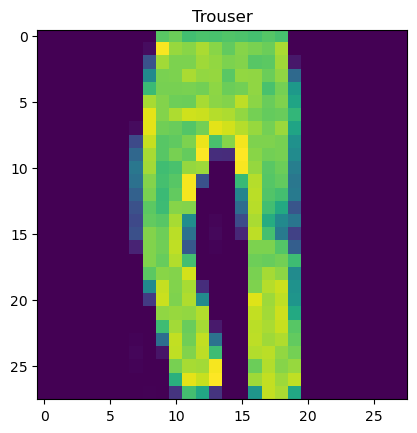

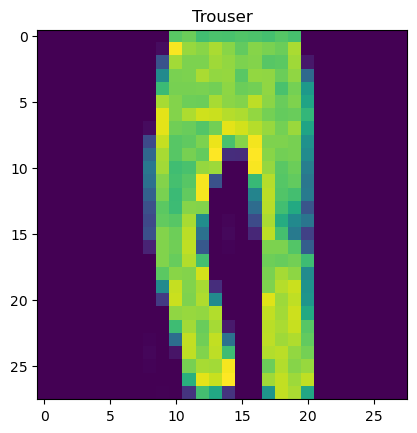

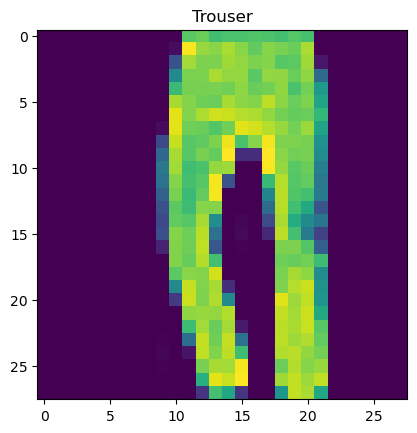

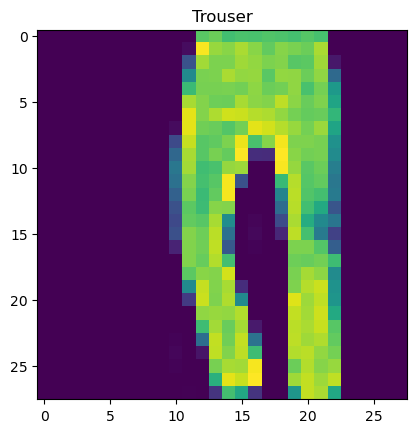

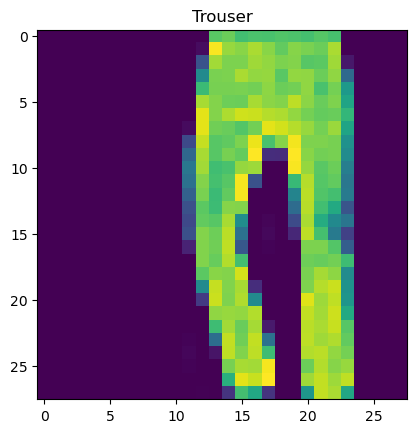

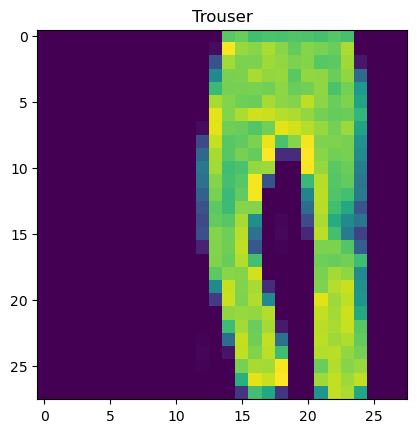

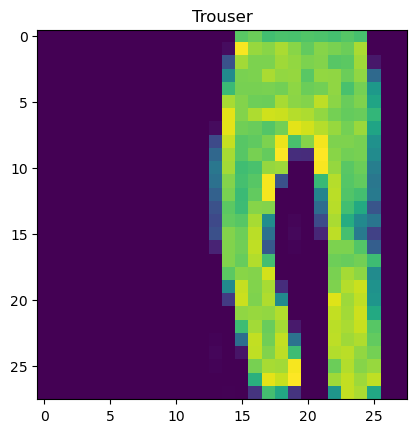

In [15]:
# Translate the image to test the model.
preds = []
ix = 24300
for px in range(-5,6):
    img = tr_images[ix]/255.
    img = img.view(28, 28)
    img2 = np.roll(img, px, axis=1)
    img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
    np_output = model(img3).cpu().detach().numpy()
    pred = np.exp(np_output)/np.sum(np.exp(np_output))
    preds.append(pred)
    plt.imshow(img2)
    plt.title(fmnist.classes[pred[0].argmax()])
    plt.show()

<Axes: title={'center': 'Probability of each class for various translations'}>

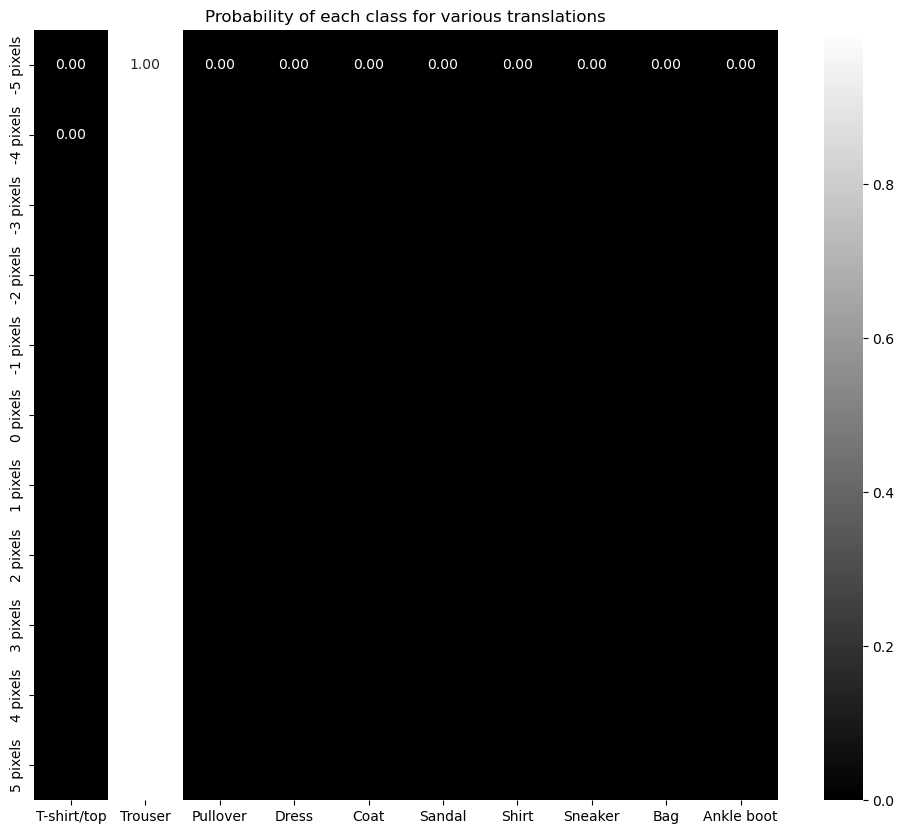

In [17]:
# Plot the prediction class across different translations.
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels')for i in range(-5,6)], cmap='gray')